In [20]:
import matplotlib.pyplot as plt
import numpy as np
import operator
import cv2
%matplotlib inline

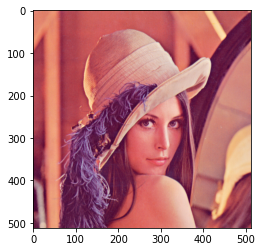

In [21]:
sample_img = cv2.imread('test_image.png', 1)
RGB_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
reduced_img = RGB_img.copy()

plt.imshow(RGB_img)
plt.show()

GRAYSCALE

In [22]:
def grayscale(img):
  r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
  gray = 0.21 * r + 0.71 * g + 0.08 * b
  return gray

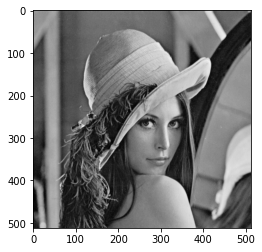

In [23]:
plt.imshow(grayscale(RGB_img), cmap='gray')
plt.show()

BLUR

In [24]:
def convolution(img, kernel):
    iHeight = img.shape[0]
    iWidth = img.shape[1]
    kHeight = kernel.shape[0]
    kWidth = kernel.shape[1]
    
    if(len(img.shape) == 3):
        imagePad = np.pad(img, pad_width=((kHeight // 2, kHeight // 2),(kWidth // 2, kWidth // 2),(0,0)), mode='constant', constant_values=0).astype(np.float32)
    elif(len(img.shape) == 2):
        imagePad = np.pad(img, pad_width=((kHeight // 2, kHeight // 2),(kWidth // 2, kWidth // 2)), mode='constant', constant_values=0).astype(np.float32)
    
    height = kHeight // 2
    width = kWidth // 2
    
    imgConv = np.zeros(imagePad.shape)
    
    for i in range(height, imagePad.shape[0] - height):
        for j in range(width, imagePad.shape[1] - width):
            x = imagePad[i - height: i - height + kHeight, j - width: j - width + kWidth]
            x = x.flatten() * kernel.flatten()
            imgConv[i][j] = x.sum()
    hEnd = -height
    wEnd = -width
    
    if(height == 0):
        return imgConv[height: ,width: wEnd]
    if(width == 0):
        return imgConv[height: hEnd, width:]

    return imgConv[height: hEnd, width: wEnd]

In [25]:
def blur(img, radius=4):
    img = np.asarray(img)
    filterSize = 2 * int(4 * radius + 0.5) + 1
    gaussianFilter = np.zeros((filterSize, filterSize), np.float32)
    m = filterSize // 2
    n = filterSize // 2
    
    for x in range(-m, m + 1):
        for y in range(-n, n + 1):
            x1 = 2 * np.pi * (radius ** 2)
            x2 = np.exp(-(x ** 2 + y ** 2) / (2 * radius ** 2))
            gaussianFilter[x + m, y + n] = (1 / x1) * x2
    
    imgFiltered = np.zeros_like(img, dtype=np.float32)
    for c in range(3):
        imgFiltered[:, :] = convolution(img[:, :], gaussianFilter)
    return (imgFiltered.astype(np.uint8))

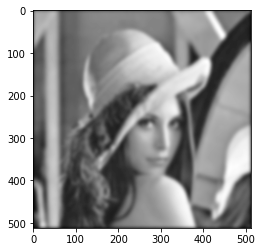

In [26]:
plt.imshow(blur(grayscale(RGB_img)), cmap='gray')
plt.show()

SOBEL

In [27]:
def sobel(img):
  Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
  Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
  [rows, columns] = np.shape(img)
  sobelImg = np.zeros(shape=(rows, columns))
  for i in range(rows - 2):
    for j in range(columns - 2):
        gx = np.sum(np.multiply(Gx, img[i: i + 3, j: j + 3]))
        gy = np.sum(np.multiply(Gy, img[i: i + 3, j: j + 3]))
        sobelImg[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)
  return sobelImg

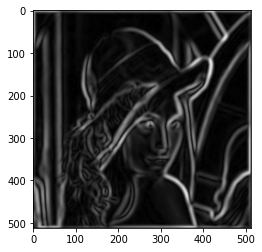

In [28]:
plt.imshow(sobel(blur(grayscale(RGB_img))), cmap='gray')
plt.show()

NMS

In [29]:
def nms(img, theta=1):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)

    angle = theta * 180. / np.pi
    if angle < 0: angle += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            q = 255
            r = 255
            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                r = img[i, j - 1]
                q = img[i, j + 1]
            elif (22.5 <= angle < 67.5):
                r = img[i - 1, j + 1]
                q = img[i + 1, j - 1]
            elif (67.5 <= angle < 112.5):
                r = img[i - 1, j]
                q = img[i + 1, j]
            elif (112.5 <= angle < 157.5):
                r = img[i + 1, j + 1]
                q = img[i - 1, j - 1]

            if (img[i, j] >= q) and (img[i, j] >= r):
                Z[i, j] = img[i, j]
            else:
                Z[i, j] = 0
    return Z

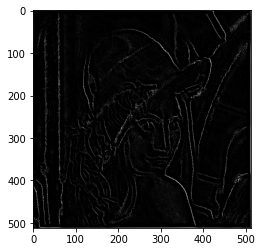

In [30]:
plt.imshow(nms(sobel(blur(grayscale(RGB_img)))), cmap='gray')
plt.show()

HISTERESIS THRESHOLDING

In [31]:
def ht(img: np.ndarray, lowRatio=0.05, highRatio=0.09, weak=np.int32(25)):
    highThreshold = img.max() * highRatio
    lowThreshold = highThreshold * lowRatio
    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)
    strong = np.int32(255)
    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if (res[i, j] == weak):
                if (
                    (res[i + 1, j - 1] == strong) or (res[i + 1, j] == strong) or
                    (res[i + 1, j + 1] == strong) or (res[i, j - 1] == strong) or
                    (res[i, j + 1] == strong) or (res[i - 1, j - 1] == strong) or
                    (res[i - 1, j] == strong) or (res[i - 1, j + 1] == strong)
                ):
                    res[i, j] = strong
                else:
                    res[i, j] = 0

    return res

**CANNY DETECTOR**

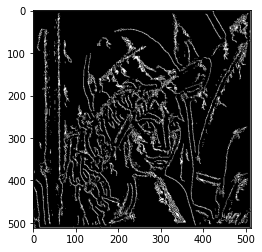

In [32]:
canny = ht(nms(sobel(blur(grayscale(RGB_img)))))
plt.imshow(canny, cmap='gray')
plt.show()

MEDIAN CUT

In [33]:
def median_cut_quantize(img, img_arr):
    r_average = np.mean(img_arr[: , 0])
    g_average = np.mean(img_arr[: , 1])
    b_average = np.mean(img_arr[: , 2])
    
    for data in img_arr:
        img[data[3]][data[4]] = [r_average, g_average, b_average]

IMPARTIREA IN LISTE

In [34]:
def split_into_buckets(img, img_arr, depth=4):
    
    if len(img_arr) == 0:
        return 
        
    if depth == 0:
        median_cut_quantize(img, img_arr)
        return
    
    r_range = np.max(img_arr[: , 0]) - np.min(img_arr[: , 0])
    g_range = np.max(img_arr[: , 1]) - np.min(img_arr[: , 1])
    b_range = np.max(img_arr[: , 2]) - np.min(img_arr[: , 2])
    
    space_with_highest_range = 0

    if g_range >= r_range and g_range >= b_range:
        space_with_highest_range = 1
    elif b_range >= r_range and b_range >= g_range:
        space_with_highest_range = 2
    elif r_range >= b_range and r_range >= g_range:
        space_with_highest_range = 0

    img_arr = img_arr[img_arr[: , space_with_highest_range].argsort()]
    median_index = int((len(img_arr) + 1) / 2)
    
    split_into_buckets(img, img_arr[0: median_index], depth - 1)
    split_into_buckets(img, img_arr[median_index: ], depth - 1)

REDUCE COLORS

In [35]:
flattened_img_array = []
for rindex, rows in enumerate(reduced_img):
  for cindex, color in enumerate(rows):
      flattened_img_array.append([color[0],color[1],color[2],rindex, cindex]) 

flattened_img_array = np.array(flattened_img_array)
split_into_buckets(reduced_img, flattened_img_array)

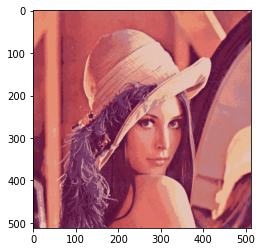

In [36]:
plt.imshow(reduced_img)
plt.show()